## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from text import text_to_sequence
from audio import init_stft, mel_spectrogram

from denoiser import Denoiser

import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/olehmatsuk/opt/anaconda3/envs/taco/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [4]:
waveglow_path = '../waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Load Model

In [8]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/ck_54'

model = Tacotron2(hparams)
if checkpoint_path is not None: 
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])

#### Prepare voice

In [9]:
voice = '/Users/olehmatsuk/Thesis/data/konekorpus/Birgit_Itse/20051203-0930ER_uudised_2005_12_03_08_30_107.995_110.099_planned_high_studio.wav'

stft = init_stft(hparams)
mel_input = mel_spectrogram(voice, stft)

#### Infer

In [12]:
def infer(model, text, voice, denoise=True):
    sequence = torch.tensor(text_to_sequence(text, hparams.text_cleaners), dtype=torch.long)
    
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference((sequence.unsqueeze(0), mel_input.T.unsqueeze(0)))
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    
    with torch.no_grad():
        audio = waveglow.cpu().infer(mel_outputs_postnet.transpose(1, 2), sigma=0.666)[0]

    if denoise:
        audio = denoiser(audio.unsqueeze(0), strength=0.01)[:, 0]

    return ipd.Audio(audio.data.numpy(), rate=hparams.sampling_rate)

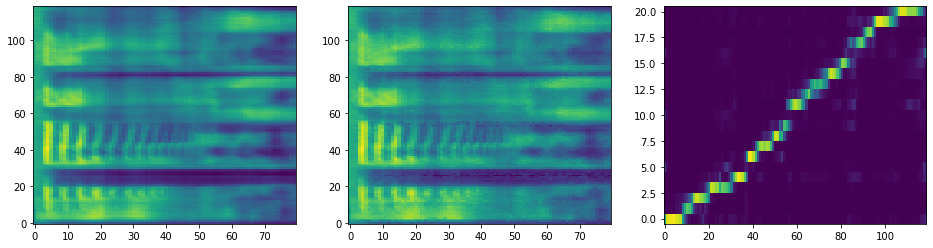

In [13]:
text = 'ärata mind seest üles'

infer(model, text, voice)